In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors


EMBEDDING_FILES = [
    '/content/drive/My Drive/RDS Project/crawl-300d-2M.gensim',
    '/content/drive/My Drive/RDS Project/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix


def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)

    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model


train_df = pd.read_csv('/content/drive/My Drive/RDS Project/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/RDS Project/test.csv')

x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)


sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)

path = '/content/drive/My Drive/RDS Project/submission.csv'
submission.to_csv(path, index=False)


"\nsample_weights = np.ones(len(x_train), dtype=np.float32)\nsample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)\nsample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)\nsample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5\nsample_weights /= sample_weights.mean()\n\nembedding_matrix = np.concatenate(\n    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)\n\ncheckpoint_predictions = []\nweights = []\n\nfor model_idx in range(NUM_MODELS):\n    model = build_model(embedding_matrix, y_aux_train.shape[-1])\n    for global_epoch in range(EPOCHS):\n        model.fit(\n            x_train,\n            [y_train, y_aux_train],\n            batch_size=BATCH_SIZE,\n            epochs=1,\n            verbose=2,\n            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]\n        )\n        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())\n        

In [ ]:
model.save('/content/drive/My Drive/RDS Project/checkpoint1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Explanability

In [1]:
import shap, sklearn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [4]:
model = load_model('/content/drive/My Drive/RDS Project/checkpoint1.h5')

In [ ]:
def build_model_wrapper(model):
    return Model(inputs=model.input, outputs=model.output[0])
model_wrapper = build_model_wrapper(model)
explainer = shap.Explainer(model_wrapper, x_train[:,:1000], output_names=y_train[:1000])
shap_values = explainer.shap_values(x_train[:,:1000])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for column in IDENTITY_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Identity Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for column in AUX_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Aux Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

# Evaluations

In [ ]:
import numpy as np
import pandas as pd

test_df = pd.read_csv('/content/drive/My Drive/RDS Project/test_private_expanded.csv')
result=pd.read_csv('/content/drive/My Drive/RDS Project/submission.csv')

In [ ]:
joint_df = pd.merge(result, test_df, on='id', how='inner')

In [ ]:
result.head()

,id,prediction
0,7097320,0.015610
1,7097321,0.074360
2,7097322,0.433029
3,7097323,0.051532
4,7097324,0.015087


In [ ]:
joint_df[joint_df['black']==1][['prediction','comment_text','toxicity']]

,prediction,comment_text,toxicity
79,0.195626,States rights and white supremacy are not mutu...,0.166667
546,0.651937,Are you trying to say that black people are mo...,0.729730
1139,0.849064,Bullshit. If you are black the rules are diff...,0.850000
1467,0.421005,Why because police show up after the crime? Or...,0.000000
1567,0.318088,Negro is derived from the Latin word Nigra whi...,0.200000
...,...,...,...
95585,0.134767,"A long time ago, in the 1960's-1970's my mothe...",0.166667
95895,0.429560,Give scholarship to black kids.,0.833333
96135,0.416969,He would of got life if he was black. He inten...,0.000000
96458,0.253300,"Especially in Trump states, but generally in t...",0.600000


In [ ]:
test_df[test_df['black']==1].shape[0]

379

In [ ]:
def accuracy_metric(joint_df):
  true_positive = len(joint_df[(joint_df['prediction'] > 0.5) & (joint_df['toxicity'] > 0.5)])
  true_negative = len(joint_df[(joint_df['prediction'] < 0.5) & (joint_df['toxicity'] < 0.5)])
  false_positive = len(joint_df[(joint_df['prediction'] > 0.5) & (joint_df['toxicity'] < 0.5)])
  false_negative = len(joint_df[(joint_df['prediction'] < 0.5) & (joint_df['toxicity'] > 0.5)])
  accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
  return accuracy

accuracy = accuracy_metric(joint_df)
print(f"Overall Accuracy of the model: {accuracy}")

Accuracy of the model: 0.9550828167122971


In [ ]:
def precision_metric(joint_df):
  true_positive = len(joint_df[(joint_df['prediction'] > 0.5) & (joint_df['toxicity'] > 0.5)])
  false_positive = len(joint_df[(joint_df['prediction'] > 0.5) & (joint_df['toxicity'] < 0.5)])
  precision = true_positive / (true_positive + false_positive)
  return precision

def recall_metric(joint_df):
  true_positive = len(joint_df[(joint_df['prediction'] > 0.5) & (joint_df['toxicity'] > 0.5)])
  false_negative = len(joint_df[(joint_df['prediction'] < 0.5) & (joint_df['toxicity'] > 0.5)])
  recall = true_positive / (true_positive + false_negative)
  return recall

precision = precision_metric(joint_df)
recall = recall_metric(joint_df)
print(f"Precision of the model: {precision}")
print(f"Recall of the model: {recall}")

Precision of the model: 0.5908761766835626
Recall of the model: 0.8458880442294402


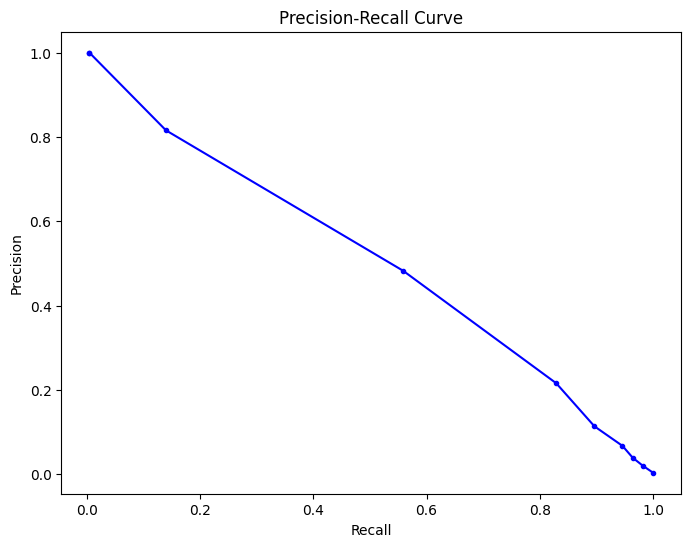

In [ ]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(joint_df):
  precisions, recalls, thresholds = [], [], []
  for threshold in np.arange(0, 1, 0.1):
    y_pred = (joint_df['prediction'] > threshold).astype(int)
    tp = len(joint_df[(y_pred == 1) & (joint_df['toxicity'] == 1)])
    fp = len(joint_df[(y_pred == 1) & (joint_df['toxicity'] == 0)])
    fn = len(joint_df[(y_pred == 0) & (joint_df['toxicity'] == 1)])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)
    thresholds.append(threshold)
  plt.figure(figsize=(8, 6))
  plt.plot(recalls, precisions, marker='.', linestyle='-', color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.show()

plot_precision_recall_curve(joint_df)


In [ ]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
TOXICITY_COLUMN = 'toxicity'
MODEL_NAME = 'prediction'

joint_df['toxicity'] = joint_df['toxicity'].apply(lambda x: True if x > 0.5 else False)
for column in identity_columns:
    joint_df[column] = np.where(joint_df[column] >= 0.5, True, False)
joint_df.head()

,id,prediction,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7097320,0.015610,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN
1,7097321,0.074360,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,...,0.0,False,False,0.0,0.0,0.0,0.0,0.0,False,0.0
2,7097322,0.433029,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,...,0.0,False,False,0.0,0.0,0.0,0.0,0.0,False,0.0
3,7097323,0.051532,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN
4,7097324,0.015087,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN


In [ ]:
from sklearn import metrics

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = pd.concat([subgroup_negative_examples, non_subgroup_positive_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = pd.concat([subgroup_positive_examples, non_subgroup_negative_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(joint_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,538,0.847290,0.954005,0.937241
5,muslim,1054,0.868018,0.965104,0.930585
7,white,1178,0.879346,0.957916,0.946551
6,black,761,0.895120,0.956965,0.947862
4,jewish,411,0.927227,0.975238,0.941109
0,male,2112,0.947126,0.976657,0.953000
1,female,2602,0.957686,0.983219,0.950468
8,psychiatric_or_mental_illness,238,0.959737,0.965057,0.972469
3,christian,2109,0.961037,0.984079,0.943800


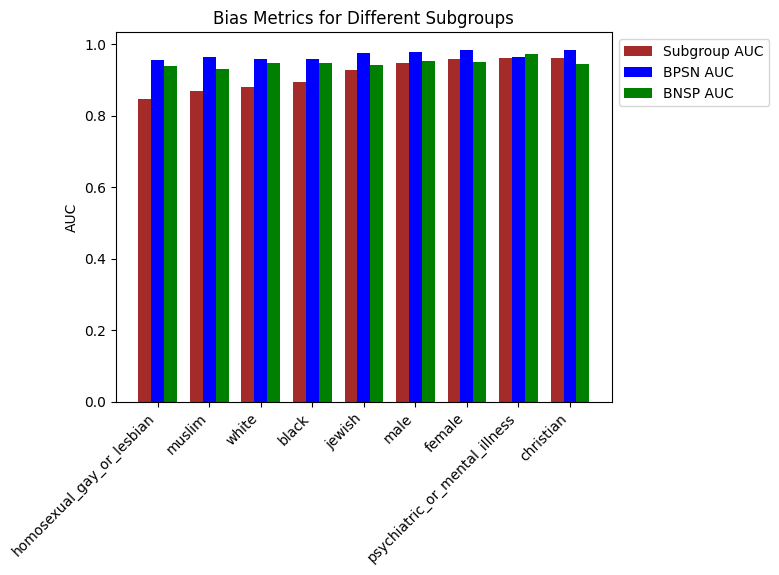

In [ ]:
# prompt: The plot is good, but i want the three types of auc to be 3 different bars instead of stacking them together

import matplotlib.pyplot as plt

subgroups = bias_metrics_df['subgroup']
subgroup_auc = bias_metrics_df[SUBGROUP_AUC]
bpsn_auc = bias_metrics_df[BPSN_AUC]
bnsp_auc = bias_metrics_df[BNSP_AUC]

x = np.arange(len(subgroups))
width = 0.25

fig, ax = plt.subplots()

rects1 = ax.bar(x-width, subgroup_auc, width, label='Subgroup AUC', color='brown')
rects2 = ax.bar(x, bpsn_auc, width, label='BPSN AUC', color='blue')
rects3 = ax.bar(x+width, bnsp_auc, width, label='BNSP AUC', color='green')

ax.set_xticks(x)
ax.set_xticklabels(subgroups, rotation=45, ha='right')

ax.set_ylabel('AUC')
ax.set_title('Bias Metrics for Different Subgroups')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.show()


In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

get_final_metric(bias_metrics_df, calculate_overall_auc(joint_df, MODEL_NAME))

0.9503460982860675

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for column in IDENTITY_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Identity Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for column in AUX_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Aux Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
for column in identity_columns:
    fpr, tpr, _ = roc_curve(joint_df[joint_df[column]][TOXICITY_COLUMN],joint_df[joint_df[column]][MODEL_NAME])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (column, roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Identity Columns')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()